In [1]:
import os 
os.environ['TP_CPP_MIN_LOG_LEVEL'] = '2'
import math
import random
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-08 14:19:30.718789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/simon/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## I. Data Generation

In [2]:
BASE_DIR = 'data/star-wars-images/'
names = ['YODA', 'LUKE SKYWALKER', 'R2-D2', 'MACE WINDU', 'GENERAL GRIEVOUS']
tf.random.set_seed(1)

In [3]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
orig_folders = ['0001/', '0002/', '0003/', '0004/', '0005/']
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images *0.6) + 0.5)
    n_valid = int((number_of_images *0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)

    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + 'train/' + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + 'val/' + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + 'test/' + names[folder_idx])


FileNotFoundError: [Errno 2] No such file or directory: 'data/star-wars-images/0001/'

## II. Prepare Data

In [5]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'data/star-wars-images/train',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=True, 
    color_mode = 'rgb',
    classes = names
)

val_batches = train_gen.flow_from_directory(
    'data/star-wars-images/val',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=False, 
    color_mode = 'rgb',
    classes = names
)

test_batches = train_gen.flow_from_directory(
    'data/star-wars-images/test',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=False, 
    color_mode = 'rgb',
    classes = names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [6]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])

test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[0. 1. 4. 2.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


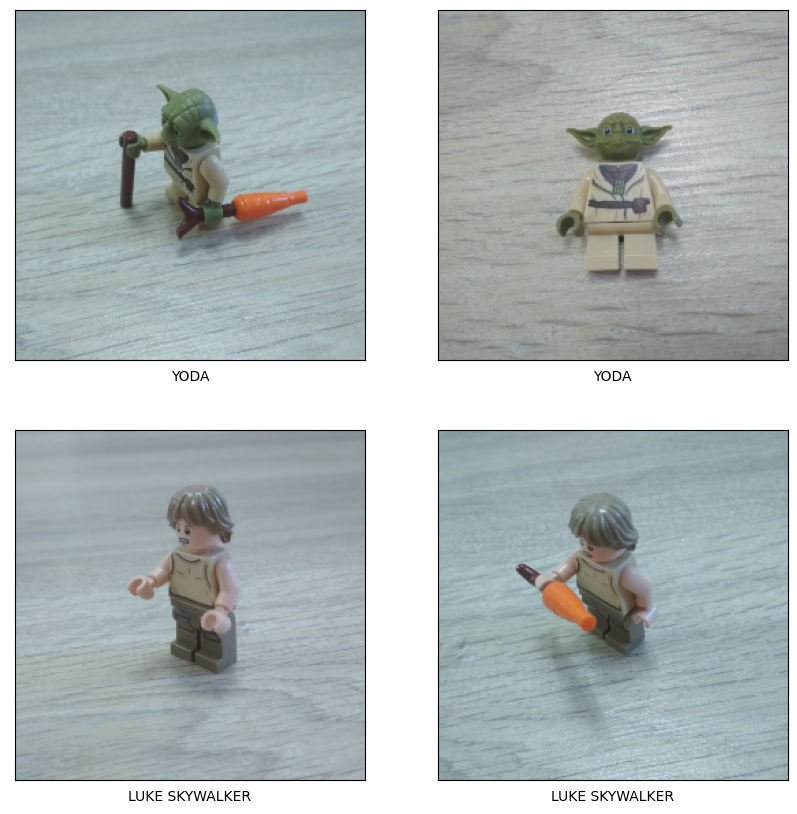

In [7]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)

        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

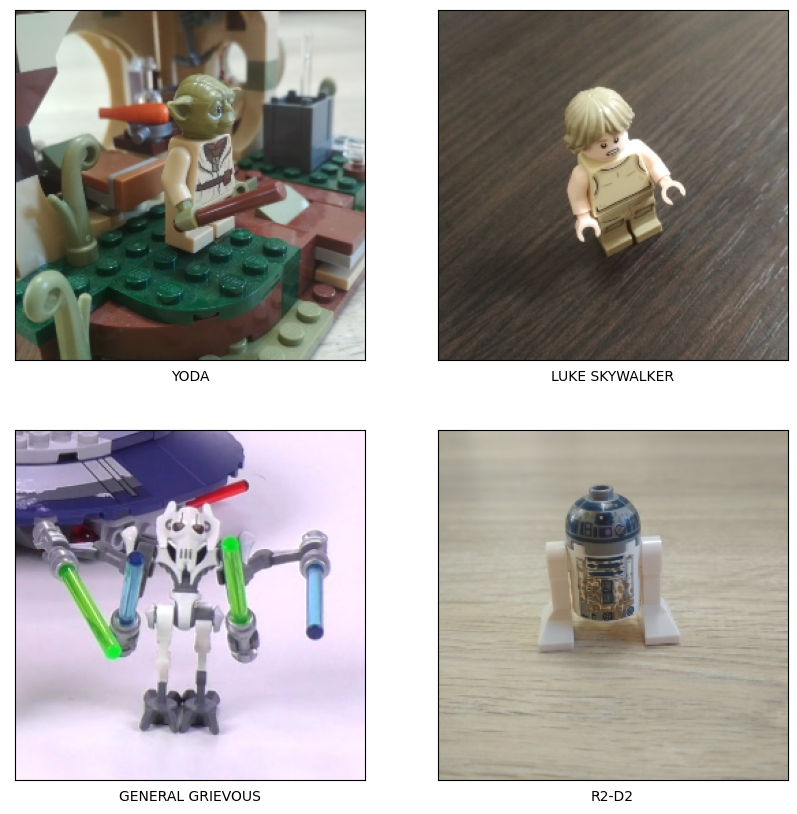

In [8]:
show(train_batch)

## III. Model

In [9]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [10]:
# loss and optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['Accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### III. a) Training

In [11]:
epochs = 50

history = model.fit(x=train_batches, validation_data = val_batches, epochs=epochs, verbose=1)

Epoch 1/50
10/10 [==============================] - 9s 596ms/step - loss: 5.1458 - Accuracy: 0.1351 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 2/50
10/10 [==============================] - 5s 499ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 3/50
10/10 [==============================] - 5s 552ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 4/50
10/10 [==============================] - 5s 451ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 5/50
10/10 [==============================] - 5s 488ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 6/50
10/10 [==============================] - 5s 518ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 7/50
10/10 [==============================] - 5s 505ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 

In [12]:
model.save('lego_model.h5')

/Users/simon/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


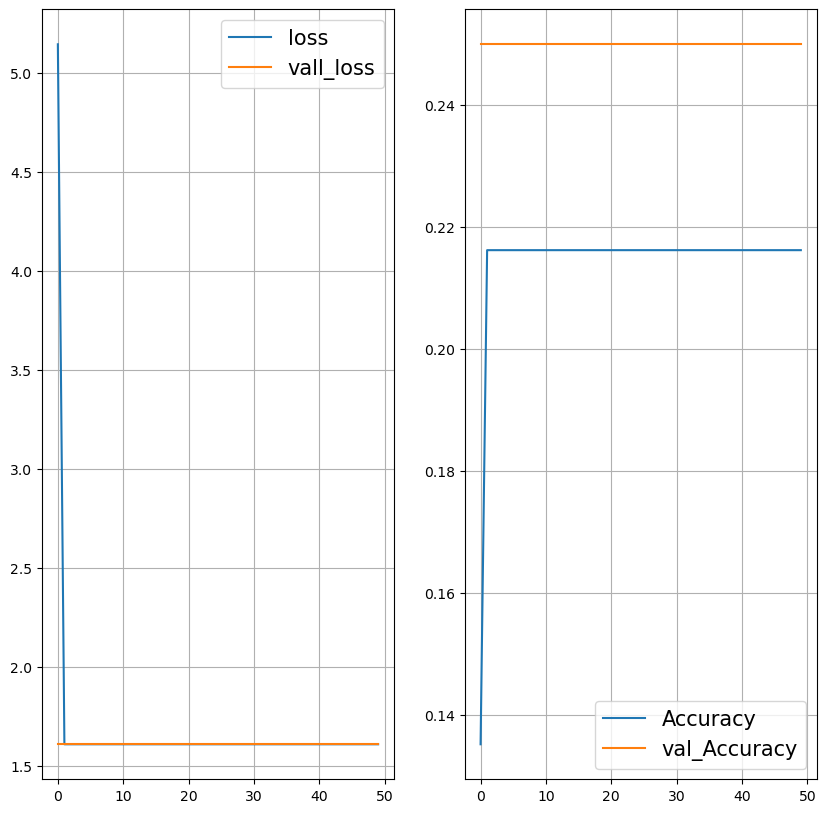

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='vall_loss')
plt.legend(fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'], label='Accuracy')
plt.plot(history.history['val_Accuracy'], label='val_Accuracy')
plt.legend(fontsize=15)
plt.grid()

## IV: Evaluation

In [14]:
model.evaluate(test_batches, verbose=1)

3/3 [==============================] - 0s 83ms/step - loss: 1.6094 - Accuracy: 0.2000


[1.6094379425048828, 0.20000000298023224]

In [15]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 1s 84ms/step
[0. 0. 1. 1.]
[4 4 4 4]


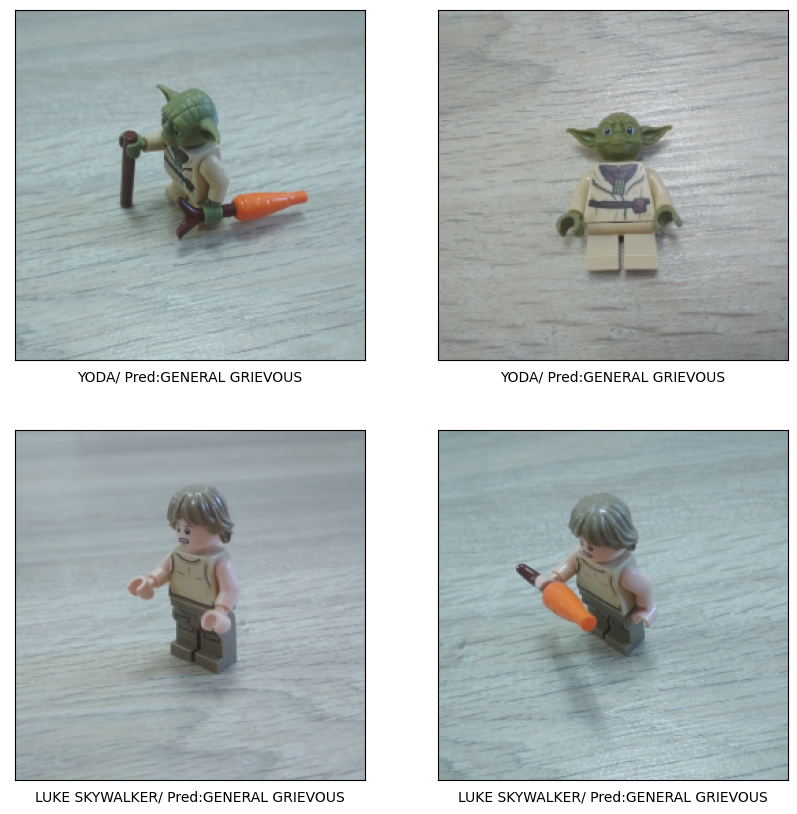

In [16]:
show(test_batches[0], labels[0:4])

# Transfer Learning

In [17]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

553467096/553467096 [==============================] - 1323s 2us/step
<class 'keras.src.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
        

In [41]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [42]:
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [43]:
model.add(layers.Dense(5))
model.summary()
# loss & optimizer:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [44]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [45]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'data/star-wars-images/train',
    target_size = (224, 224),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=True, 
    color_mode = 'rgb',
    classes = names
)

val_batches = train_gen.flow_from_directory(
    'data/star-wars-images/val',
    target_size = (224, 224),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=True, 
    color_mode = 'rgb',
    classes = names
)

test_batches = train_gen.flow_from_directory(
    'data/star-wars-images/test',
    target_size = (224, 224),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=False, 
    color_mode = 'rgb',
    classes = names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [46]:
epochs = 15

history = model.fit(train_batches, validation_data=val_batches, epochs=epochs, verbose=2)

Epoch 1/15
10/10 - 25s - loss: 1.8422 - accuracy: 0.4324 - val_loss: 0.3771 - val_accuracy: 0.7500 - 25s/epoch - 3s/step
Epoch 2/15
10/10 - 22s - loss: 0.1553 - accuracy: 0.9730 - val_loss: 0.3176 - val_accuracy: 0.9375 - 22s/epoch - 2s/step
Epoch 3/15
10/10 - 21s - loss: 0.0505 - accuracy: 0.9730 - val_loss: 0.3104 - val_accuracy: 0.8750 - 21s/epoch - 2s/step
Epoch 4/15
10/10 - 21s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.2741 - val_accuracy: 0.8750 - 21s/epoch - 2s/step
Epoch 5/15
10/10 - 20s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2569 - val_accuracy: 0.8750 - 20s/epoch - 2s/step
Epoch 6/15
10/10 - 20s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2462 - val_accuracy: 0.9375 - 20s/epoch - 2s/step
Epoch 7/15
10/10 - 20s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.9375 - 20s/epoch - 2s/step
Epoch 8/15
10/10 - 19s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2378 - val_accuracy: 0.9375 - 19s/epoch - 2s/step
Epoch 9/15
10/10 - 19s - loss: 0

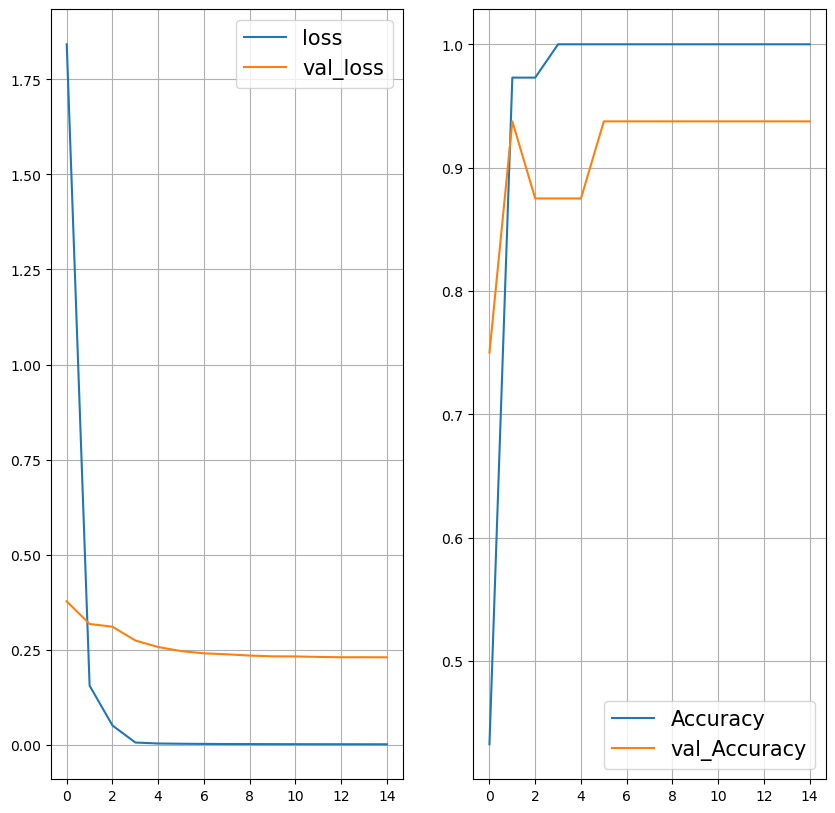

In [48]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='val_Accuracy')
plt.legend(fontsize=15)
plt.grid()